In [83]:
## HYBRID APPROACH OF SARIMA TIME SERIES AND LOGISTIC REGRESSION ANALYSIS IN FORECASTING THE SUICIDE RATES IN KENYA BETWEEN 2000 AND 2019
# Main objective is to forecast suicide rates for the next 5 years from December 31st 2019
# General objective is to test which model of the two will accurately forecast the data

# let's load the necessary packages for analysis
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# STEP 1: Data Preparation; load the data and manipulate the date to achieve consistency
df = pd.read_csv("datasets/clean.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index("date", inplace = True)
list(df.columns.values) # to investigate
# the column names contain whitespaces which is problematic

[' Total', ' Male', ' Female']

In [36]:
# to remove the whitespaces
df = pd.read_csv("datasets/clean.csv", skipinitialspace = True)
df['date'] = pd.to_datetime(df['date'])
df.set_index("date", inplace = True)
# to check whether the whitespaces are still there
list(df.columns.values)
# data is clean now

['Total', 'Male', 'Female']

In [37]:
df.head(5)

,Total,Male,Female
date,,,
2000-12-31,7.6,10.8,4.4
2001-12-31,6.9,10.0,3.9
2002-12-31,6.4,9.4,3.6
2003-12-31,6.1,9.0,3.2
2004-12-31,5.7,8.6,2.7


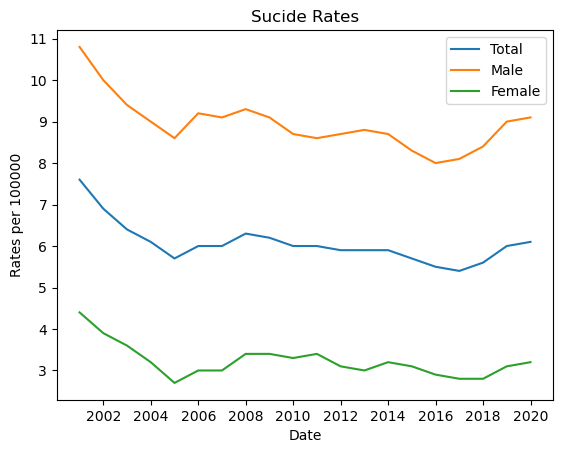

' The plot does not exhibit any significance of seasonal effects, hence \na good model would be that of ARIMA in order to focus on capturing the \nautoregressive and moving average patterns for better interpretation'

In [38]:
# STEP 2: Visualization to observe trend and seasonality

plt.plot(df['Total'], label='Total')
plt.plot(df.index, df['Male'], label='Male')
plt.plot(df.index, df['Female'], label='Female')
plt.xlabel('Date')
plt.ylabel('Rates per 100000')
plt.title('Sucide Rates')
plt.legend()
plt.show()
''' The plot does not exhibit any significance of seasonal effects, hence 
a good model would be that of ARIMA in order to focus on capturing the 
autoregressive and moving average patterns for better interpretation'''

In [61]:
# STEP 3: To check for stationarity, to make sure data faithfully
# reflects the underlying patterns in the data for accuracy.
# we can test using the Augmwnted Dickey-Fuller test
''' the hypothesis used:
H0: Series is non-stationary
Ha: Series is stationary

if ADF Statistic < Critical Value and p-value < 0.05, reject Ho,
time series is stationary'''
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test
test_stationarity(df['Total'])

Results of Dickey-Fuller Test:
Test Statistic                  1.345995
p-value                         0.996854
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [63]:
# the series is non-stationary. to correct this, '''
# we use the square root of the data using the following steps

#1.) Use NumPy’s square root function to transform the required column
#2.) Then shift the transformation by one using the “shift’ function.
#3.) Take the difference between both the original transformation and shift.
#4.) Steps 2 and 3 can be done by just using the pandas “diff” function

df_log = np.sqrt(df['Total'])
df_diff = df_log.diff().dropna()
# let's test for stationarity
test_stationarity(df_diff)  # it is now stationary

Results of Dickey-Fuller Test:
Test Statistic                 -2.866284
p-value                         0.049412
#Lags Used                      7.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


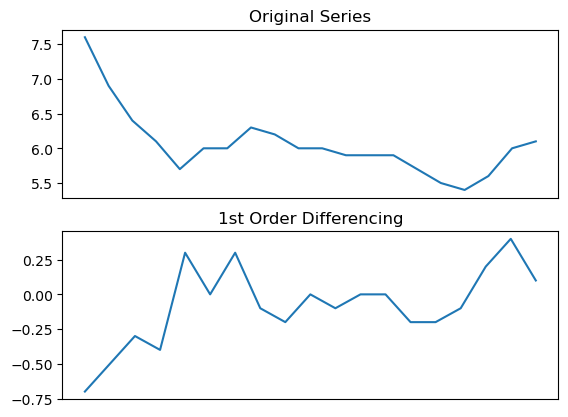

In [79]:
# let's compare better the two
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df['Total']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df['Total'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
plt.show()

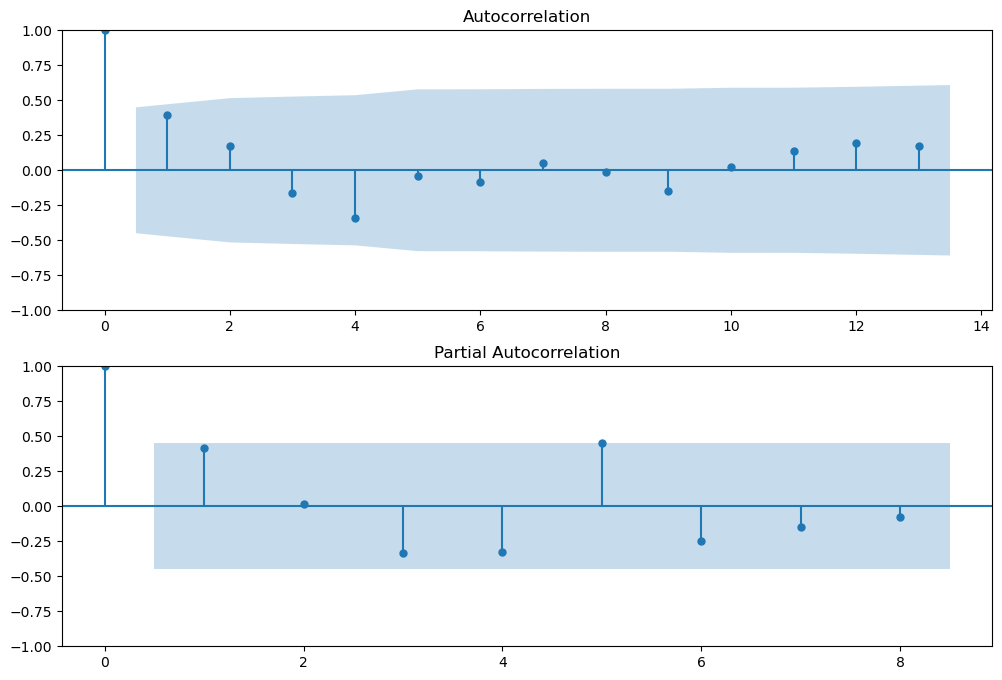

In [73]:
# STEP 4: plotting ACF and PCF to identify potential p and q in ARIMA(p,d,q)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.simplefilter('ignore')

# Plot autocorrelation and partial autocorrelation functions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, ax=ax1)
plot_pacf(df_diff, lags=8, ax=ax2)
plt.show()

In [77]:
# here we can see that p = 1 and q = 2. d = 1

In [96]:
# STEP 5: fit the SARIMA model
p,d,q = 1,1,2 # ARIMA(p.d.q)

sarima_model = sm.tsa.ARIMA(df['Total'], order = (p,d,q))
model_fit = sarima_model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   20
Model:                 ARIMA(1, 1, 2)   Log Likelihood                   2.265
Date:                Tue, 01 Aug 2023   AIC                              3.469
Time:                        10:45:48   BIC                              7.247
Sample:                    12-31-2000   HQIC                             4.109
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0543      0.468     -0.116      0.908      -0.972       0.863
ma.L1          0.7125      3.000      0.238      0.812      -5.167       6.592
ma.L2          0.9881      7.993      0.124      0.9

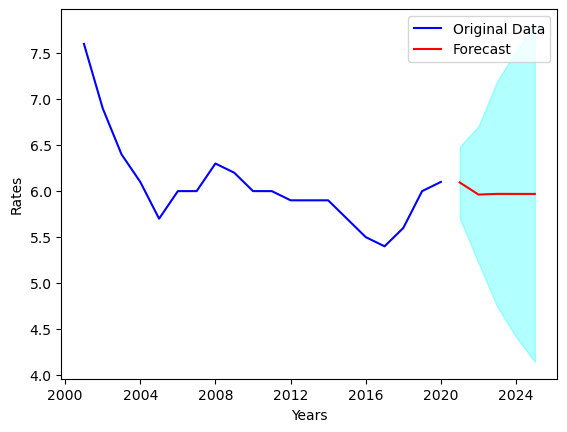

In [100]:
# STEP 6: FORECASTING

# Forecast for the next 5 years
forecast_steps = 5
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the original data and the forecasted values
plt.plot(df.index, df['Total'], label='Original Data', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')

# Plot the uncertainty intervals
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='cyan', alpha=0.3)

plt.xlabel('Years')
plt.ylabel('Rates')
plt.legend()
plt.show()

In [128]:
# Logistic Regression to check for the relationship between gender
# and suicide rates
# let's load the machine learning package scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [129]:
# Target variable = gender and features = suicide rates
regData = pd.read_csv('datasets/gender_suicide.csv', skipinitialspace = True)

In [134]:
X = regData[['suicide_rates']]  # Feature in 2D array
y = regData['gender']  # Target variable Male = 1, Female = 0

# Split the data into 70% training and 30% testing sets
# this is done to evaluate the model's performance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [135]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [137]:
# predictions
y_pred = logistic_model.predict(X_test)
print(y_pred)

[0 1 0 1 1 1 0 0 0 1 0 0]


In [138]:
# let's create a dataframe and compare predicted and actual values

result = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
result

,Actual,Predicted
19,0,0
16,1,1
15,0,0
26,1,1
4,1,1
12,1,1
37,0,0
27,0,0
39,0,0
6,1,1


In [139]:
# To evaluate model performance

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix = the number of gender predictions column-wise
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# accuracy is at 100%. since the dataset is small, there is a great of overfitting,
# which might explain why the accuracy is at 100%.

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Confusion Matrix:
[[7 0]
 [0 5]]


In [140]:
# The coef_ and intercept_ attributes give the model coefficient and intercept.

coefficients = logistic_model.coef_
intercept = logistic_model.intercept_

print('Coefficients:', coefficients)
print('Intercept:', intercept)

# according to the model,  the female gender has a positive effect on 
# the probability of suicide being predicted.

Coefficients: [[1.46086758]]
Intercept: [-8.77161778]
